# Import packages

In [32]:
%load_ext autoreload
%autoreload 2

import os, sys, sys
from pathlib import Path
for p in [Path.cwd()] + list(Path.cwd().parents):
    if p.name == 'Multifirefly-Project':
        os.chdir(p)
        sys.path.insert(0, str(p / 'multiff_analysis/multiff_code/methods'))
        break
    
from data_wrangling import specific_utils, process_monkey_information, general_utils
from pattern_discovery import pattern_by_trials, pattern_by_trials, cluster_analysis, organize_patterns_and_features
from visualization.matplotlib_tools import plot_behaviors_utils
from neural_data_analysis.neural_analysis_tools.get_neural_data import neural_data_processing
from neural_data_analysis.neural_analysis_tools.visualize_neural_data import plot_neural_data, plot_modeling_result
from neural_data_analysis.neural_analysis_tools.model_neural_data import transform_vars, neural_data_modeling, drop_high_corr_vars, drop_high_vif_vars
from neural_data_analysis.topic_based_neural_analysis.neural_vs_behavioral import prep_monkey_data, prep_target_data, neural_vs_behavioral_class
from neural_data_analysis.topic_based_neural_analysis.planning_and_neural import planning_and_neural_class, pn_utils, pn_helper_class, pn_aligned_by_seg, pn_aligned_by_event
from neural_data_analysis.neural_analysis_tools.cca_methods import cca_class
from neural_data_analysis.neural_analysis_tools.cca_methods import cca_class, cca_utils, cca_cv_utils
from neural_data_analysis.neural_analysis_tools.cca_methods.cca_plotting import cca_plotting, cca_plot_lag_vs_no_lag, cca_plot_cv
from machine_learning.ml_methods import regression_utils, regz_regression_utils, ml_methods_class, classification_utils, ml_plotting_utils, ml_methods_utils
from planning_analysis.show_planning import nxt_ff_utils, show_planning_utils
from neural_data_analysis.neural_analysis_tools.gpfa_methods import elephant_utils, fit_gpfa_utils, plot_gpfa_utils, gpfa_helper_class
from neural_data_analysis.neural_analysis_tools.align_trials import time_resolved_regression, time_resolved_gpfa_regression,plot_time_resolved_regression
from neural_data_analysis.neural_analysis_tools.align_trials import align_trial_utils
from decision_making_analysis.compare_GUAT_and_TAFT import find_GUAT_or_TAFT_trials

from neural_data_analysis.topic_based_neural_analysis.stop_event_analysis.stop_psth import core_stops_psth, get_stops_utils, psth_postprocessing, psth_stats, compare_events, dpca_utils, prep_stop_psth_data


import sys
import math
import gc
import subprocess
from pathlib import Path

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from scipy import linalg, interpolate
from scipy.signal import fftconvolve
from scipy.io import loadmat
from scipy import sparse
import torch
from numpy import pi
import cProfile
import pstats

# Machine Learning imports
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.multivariate.cancorr import CanCorr

# Neuroscience specific imports
import neo
import rcca

# To fit gpfa
import numpy as np
from importlib import reload
from scipy.integrate import odeint
import quantities as pq
import neo
from elephant.spike_train_generation import inhomogeneous_poisson_process
from elephant.gpfa import GPFA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from elephant.gpfa import gpfa_core, gpfa_util

plt.rcParams["animation.html"] = "html5"
os.environ['KMP_DUPLICATE_LIB_OK']='True'
rc('animation', html='jshtml')
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['animation.embed_limit'] = 2**128
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)
os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

print("done")


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
done
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# retrieve data

In [4]:
# raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Schro/data_0416"
# raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Schro/data_0321"
# raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Schro/data_0329"
# raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Schro/data_0403"
#raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Schro/data_0413"

In [5]:
# # raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0330"
# # raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0328"
# #raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0312"

# #raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0316"
# raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0327"



#raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0221"
#raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0312"
raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0327"

In [6]:
reduce_y_var_lags = False
planning_data_by_point_exists_ok = True
y_data_exists_ok = True

pn = pn_aligned_by_event.PlanningAndNeuralEventAligned(raw_data_folder_path=raw_data_folder_path)
pn.prep_data_to_analyze_planning(planning_data_by_point_exists_ok=planning_data_by_point_exists_ok)
# pn.planning_data_by_point, cols_to_drop = general_utils.drop_columns_with_many_nans(
#     pn.planning_data_by_point)
#pn.get_x_and_y_data_for_modeling(exists_ok=y_data_exists_ok, reduce_y_var_lags=reduce_y_var_lags)

if not hasattr(pn, 'spikes_df'):
    pn.retrieve_or_make_monkey_data()
    pn.spikes_df = neural_data_processing.make_spikes_df(pn.raw_data_folder_path, pn.ff_caught_T_sorted,
                                                            sampling_rate=pn.sampling_rate)

Loaded binned_spikes_df from all_monkey_data/processed_neural_data/monkey_Bruno/data_0327/binned_spikes_df_0p05.csv
Loaded planning_data_by_point from all_monkey_data/planning_and_neural/monkey_Bruno/data_0327/planning_data_by_point/opt_arc_stop_closest/test/cur_vis_0_1_window_-25cm_0cm
Loaded planning_data_by_point from all_monkey_data/planning_and_neural/monkey_Bruno/data_0327/planning_data_by_point/opt_arc_stop_closest/control/cur_vis_0_1_window_-25cm_0cm
Loaded behav_data_by_bin from all_monkey_data/target_decoder/monkey_Bruno/data_0327/behav_data_by_point.csv
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
There are 4 duplicated point_index in bin_info. Note: one_point_index_per_bin is False


In [7]:
pn.spikes_df['cluster'].max()

29

# NEXT: try stop end time instead

# Get captures

In [8]:
reload(get_stops_utils)

<module 'neural_data_analysis.topic_based_neural_analysis.stop_event_analysis.stop_psth.get_stops_utils' from '/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/topic_based_neural_analysis/stop_event_analysis/stop_psth/get_stops_utils.py'>

In [9]:
pn.make_or_retrieve_stop_category_df()

Retrieved stop_category_df


In [10]:
# Example wiring (mirrors your original usage)
captures_df, valid_captures_df, filtered_no_capture_stops_df, stops_with_stats = get_stops_utils.prepare_no_capture_and_captures(
    monkey_information=pn.monkey_information,
    closest_stop_to_capture_df=pn.closest_stop_to_capture_df,
    ff_caught_T_new=pn.ff_caught_T_new,
    distance_col="distance_from_ff_to_stop",
)   


# Get misses

##  one

In [11]:
columns_to_add = ["stop_id", "stop_id_duration", "stop_id_start_time", "stop_id_end_time"]

pn.make_one_stop_w_ff_df()
one_stop_miss_df = pn.one_stop_w_ff_df[['first_stop_point_index', 'first_stop_time', 'latest_visible_ff']].copy()
one_stop_miss_df.rename(columns={'first_stop_point_index': 'stop_point_index', 'first_stop_time': 'stop_time'}, inplace=True)
one_stop_miss_df[columns_to_add] = pn.monkey_information.loc[one_stop_miss_df['stop_point_index'], columns_to_add].values

Retrieved ff_dataframe from all_monkey_data/processed_data/monkey_Bruno/data_0327/ff_dataframe.h5


## more

In [12]:
pn.make_or_retrieve_stop_category_df()

In [13]:
pn.get_try_a_few_times_info()
pn.get_give_up_after_trying_info()


In [14]:
columns_to_add = ["stop_id", "stop_id_duration", "stop_id_start_time", "stop_id_end_time"]
shared_columns = ["stop_point_index", "stop_time"] + columns_to_add

# --- Build expanded + ordered tables for GUAT / TAFT ---
GUAT_expanded = get_stops_utils._expand_trials(pn.GUAT_trials_df, pn.monkey_information)
TAFT_expanded = get_stops_utils._expand_trials(pn.TAFT_trials_df, pn.monkey_information)

# add stop_id to GUAT_trials_df and TAFT_trials_df
GUAT_expanded[columns_to_add] = pn.monkey_information.loc[GUAT_expanded['stop_point_index'], columns_to_add].values
TAFT_expanded[columns_to_add] = pn.monkey_information.loc[TAFT_expanded['stop_point_index'], columns_to_add].values


GUAT = get_stops_utils._add_cluster_ordering(GUAT_expanded)
TAFT = get_stops_utils._add_cluster_ordering(TAFT_expanded)

# --- Per-cluster slices (consistent, vectorized) ---
# First stop in each cluster
GUAT_first = GUAT[GUAT["is_first"]].reset_index(drop=True)
TAFT_first = TAFT[TAFT["is_first"]].reset_index(drop=True)

# Last stop in each cluster
GUAT_last = GUAT[GUAT["is_last"]].reset_index(drop=True)
capture_TAFT_last = TAFT[TAFT["is_last"]].reset_index(drop=True)

# Middle stops (exclude first and last)
GUAT_middle = GUAT[GUAT["is_middle"]].reset_index(drop=True)
TAFT_middle = TAFT[TAFT["is_middle"]].reset_index(drop=True)

# “First several” = all but the last stop in each cluster
GUAT_nonfinal = GUAT[GUAT["order_in_cluster"] < GUAT["cluster_size"] - 1].reset_index(drop=True)
TAFT_nonfinal = TAFT[TAFT["order_in_cluster"] < TAFT["cluster_size"] - 1].reset_index(drop=True)

# Combine the “first several” from both, keep only columns you care about, then sort by index
both_nonfinal = (
    pd.concat(
        [
            GUAT_nonfinal[shared_columns],
            TAFT_nonfinal[shared_columns],
        ],
        ignore_index=True
    )
    .sort_values("stop_point_index")
    .reset_index(drop=True)
)

persist_both_first = pd.concat([GUAT_first[shared_columns], 
                         TAFT_first[shared_columns]])

both_middle = pd.concat([GUAT_middle[shared_columns], 
                         TAFT_middle[shared_columns]])

# Optional: if you also want “last several” (all but the first), it’s symmetrical:
# GUAT_last_several = GUAT[GUAT["order_in_cluster"] > 0].reset_index(drop=True)
# capture_TAFT_last_several = TAFT[TAFT["order_in_cluster"] > 0].reset_index(drop=True)

GUAT_last_plus_single_miss = pd.concat([GUAT_last[shared_columns], 
                                         one_stop_miss_df[shared_columns]])

all_misses = pd.concat([one_stop_miss_df[shared_columns], 
                                         GUAT_expanded[shared_columns],
                                         TAFT_nonfinal[shared_columns]
                                         ])

all_first_misses = pd.concat(
    [one_stop_miss_df[shared_columns], GUAT_first[shared_columns], TAFT_first[shared_columns]],
    ignore_index=True
)

all_last_misses = pd.concat(
    [one_stop_miss_df[shared_columns], GUAT_last[shared_columns]],
    ignore_index=True
)

# captures not in TAFT last (assuming capture_TAFT_last is a subset of captures)
captures_minus_TAFT_last = compare_events.diff_by(valid_captures_df, capture_TAFT_last, key='stop_id')

# non-captures excluding those flagged as 'all_misses'
non_captures_minus_all_misses = compare_events.diff_by(filtered_no_capture_stops_df, all_misses, key='stop_id')


# Dwell time on stops

In [15]:
pn.TAFT_trials_df

,stop_cluster_id,trial,num_stops,stop_indices,first_stop_point_index,second_stop_point_index,last_stop_point_index,first_stop_time,second_stop_time,last_stop_time,stop_cluster_size,stop_id_duration
0,20,5,2,"[6076, 6113]",6076,6113,6113,100.82587,101.43985,101.43985,2,0.33384
1,21,6,2,"[6188, 6229]",6188,6229,6229,102.65341,103.33399,103.33399,2,0.28234
2,24,8,2,"[6588, 6622]",6588,6622,6622,109.22686,109.79131,109.79131,2,0.43152
3,29,9,3,"[7018, 7055, 7092]",7018,7055,7092,116.34763,116.96171,117.57567,3,0.28310
4,31,11,2,"[7253, 7288]",7253,7288,7288,120.18269,120.76366,120.76366,2,0.29889
...,...,...,...,...,...,...,...,...,...,...,...,...
375,1487,1056,3,"[216975, 217017, 217054]",216975,217017,217054,3571.25798,3571.95520,3572.56940,3,0.44811
376,1488,1057,2,"[217122, 217190]",217122,217190,217190,3573.66498,3574.79346,3574.79346,2,0.68037
377,1493,1061,2,"[217834, 217874]",217834,217874,217874,3585.35112,3586.01516,3586.01516,2,0.63081
378,1495,1063,2,"[218442, 218482]",218442,218482,218482,3595.37736,3596.04138,3596.04138,2,0.49795


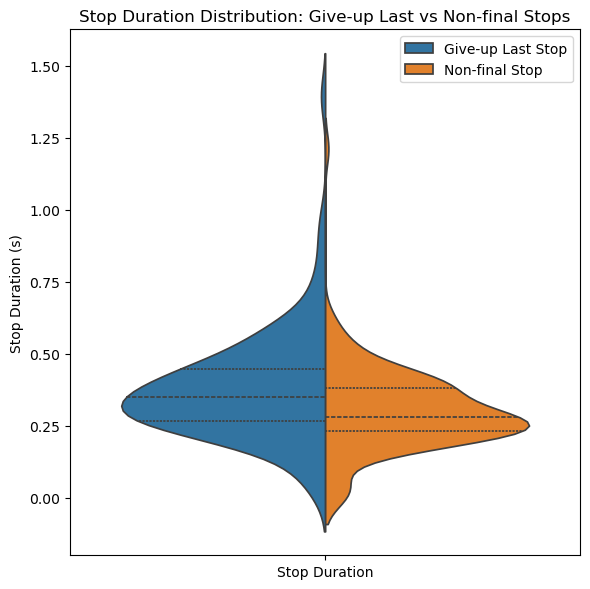

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Combine both dataframes and label them
df_compare = pd.concat([
    GUAT_last.assign(group='Give-up Last Stop'),
    GUAT_nonfinal.assign(group='Non-final Stop')
])

# Add a common x category so both appear in the same violin
df_compare['category'] = 'Stop Duration'

# Create split violin plot
plt.figure(figsize=(6, 6))
sns.violinplot(
    data=df_compare,
    x='category',
    y='stop_id_duration',
    hue='group',
    split=True,
    inner='quartile',
    width=0.8
)

# Customize
plt.xlabel('')
plt.ylabel('Stop Duration (s)')
plt.title('Stop Duration Distribution: Give-up Last vs Non-final Stops')
plt.legend(title='')
plt.tight_layout()
plt.show()


/tmp/ipykernel_2752081/2899128575.py:29: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


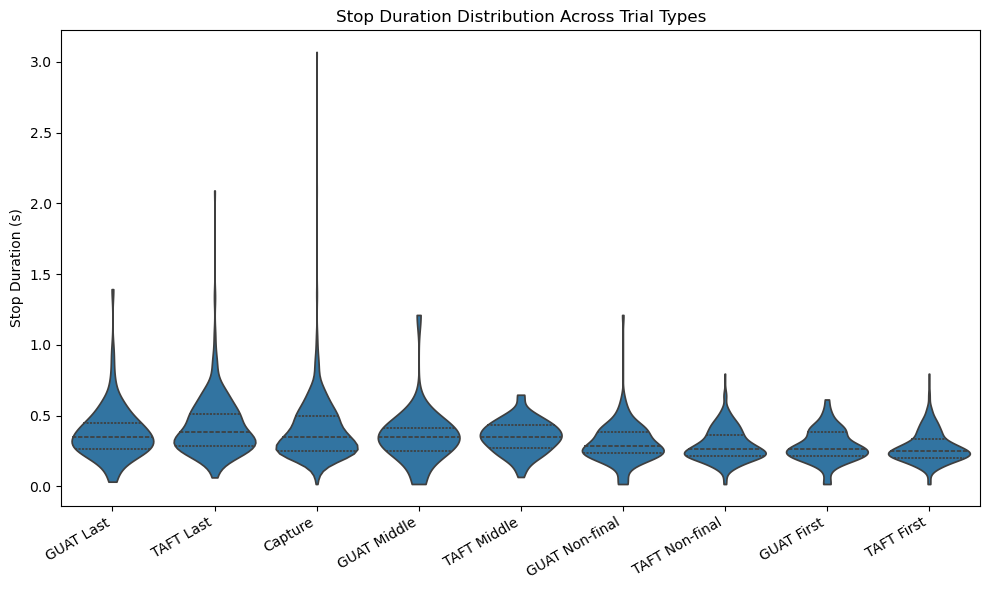

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Combine all datasets, tagging each
df_compare = pd.concat([
    GUAT_last.assign(group='GUAT Last'),
    capture_TAFT_last.assign(group='TAFT Last'),
    valid_captures_df.assign(group='Capture'),
    
    GUAT_middle.assign(group='GUAT Middle'),
    TAFT_middle.assign(group='TAFT Middle'),
    
    
    GUAT_nonfinal.assign(group='GUAT Non-final'),
    TAFT_nonfinal.assign(group='TAFT Non-final'),
    
    
    GUAT_first.assign(group='GUAT First'),
    TAFT_first.assign(group='TAFT First'),
    
    
    
    # add more as needed
])

# Plot all as separate violins
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df_compare,
    x='group',
    y='stop_id_duration',
    inner='quartile',
    cut=0,
    scale='width'
)

# Customize
plt.xticks(rotation=30, ha='right')
plt.xlabel('')
plt.ylabel('Stop Duration (s)')
plt.title('Stop Duration Distribution Across Trial Types')
plt.tight_layout()
plt.show()


/tmp/ipykernel_2752081/561306430.py:20: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


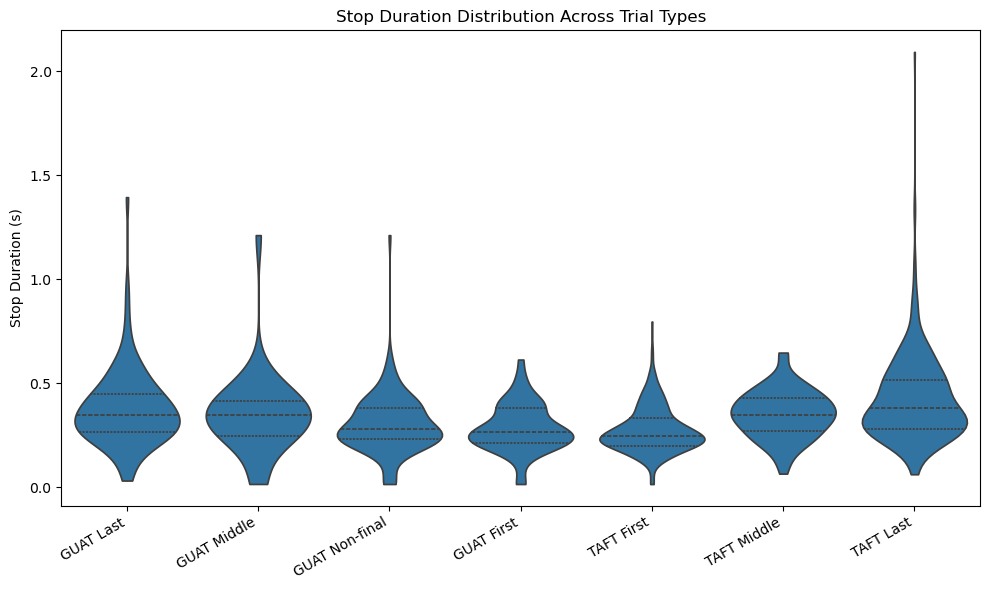

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Combine all datasets, tagging each
df_compare = pd.concat([
    GUAT_last.assign(group='GUAT Last'),
    GUAT_middle.assign(group='GUAT Middle'),
    GUAT_nonfinal.assign(group='GUAT Non-final'),
    GUAT_first.assign(group='GUAT First'),
    TAFT_first.assign(group='TAFT First'),
    
    TAFT_middle.assign(group='TAFT Middle'),
    capture_TAFT_last.assign(group='TAFT Last'),
    # add more as needed
])

# Plot all as separate violins
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df_compare,
    x='group',
    y='stop_id_duration',
    inner='quartile',
    cut=0,
    scale='width'
)

# Customize
plt.xticks(rotation=30, ha='right')
plt.xlabel('')
plt.ylabel('Stop Duration (s)')
plt.title('Stop Duration Distribution Across Trial Types')
plt.tight_layout()
plt.show()


In [19]:
valid_captures_df

,cur_ff_index,stop_id,time,point_index,stop_time,distance_from_ff_to_stop,stop_point_index,stop_id_duration,stop_id_start_time,stop_id_end_time
0,0,6,73.10374,4399,73.10374,24.87241,4399,0.25124,73.08731,73.33842
1,1,18,92.06280,5543,92.06280,8.47362,5543,0.19658,91.92997,92.13941
2,3,24,97.70595,5886,97.70595,23.15871,5886,0.21579,97.68928,97.90512
3,5,28,101.43985,6113,101.43985,8.34226,6113,0.33382,101.42322,101.75706
4,6,30,103.33399,6229,103.33399,6.57375,6229,0.21580,103.31740,103.53319
...,...,...,...,...,...,...,...,...,...,...
987,1060,2103,3580.63686,217548,3580.63686,10.79887,217548,0.94617,3580.53722,3581.48341
988,1061,2105,3586.01516,217874,3586.01516,6.81856,217874,0.63079,3585.99855,3586.62936
989,1062,2106,3590.84557,218167,3590.84557,13.95998,218167,3.07106,3590.82895,3593.90000
990,1063,2108,3596.04138,218482,3596.04138,1.60397,218482,0.49790,3596.02478,3596.52273


In [20]:
TAFT_last vs capture?

Docstring:
::

  %capture [--no-stderr] [--no-stdout] [--no-display] [output]

run the cell, capturing stdout, stderr, and IPython's rich display() calls.

positional arguments:
  output        The name of the variable in which to store output. This is a
                ``utils.io.CapturedIO`` object with stdout/err attributes for
                the text of the captured output. CapturedOutput also has a
                ``show()`` method for displaying the output, and ``__call__``
                as well, so you can use that to quickly display the output. If
                unspecified, captured output is discarded.

options:
  --no-stderr   Don't capture stderr.
  --no-stdout   Don't capture stdout.
  --no-display  Don't capture IPython's rich display.
File:      ~/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/IPython/core/magics/execution.py

/tmp/ipykernel_2752081/3662015502.py:2: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/tmp/ipykernel_2752081/3662015502.py:10: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(


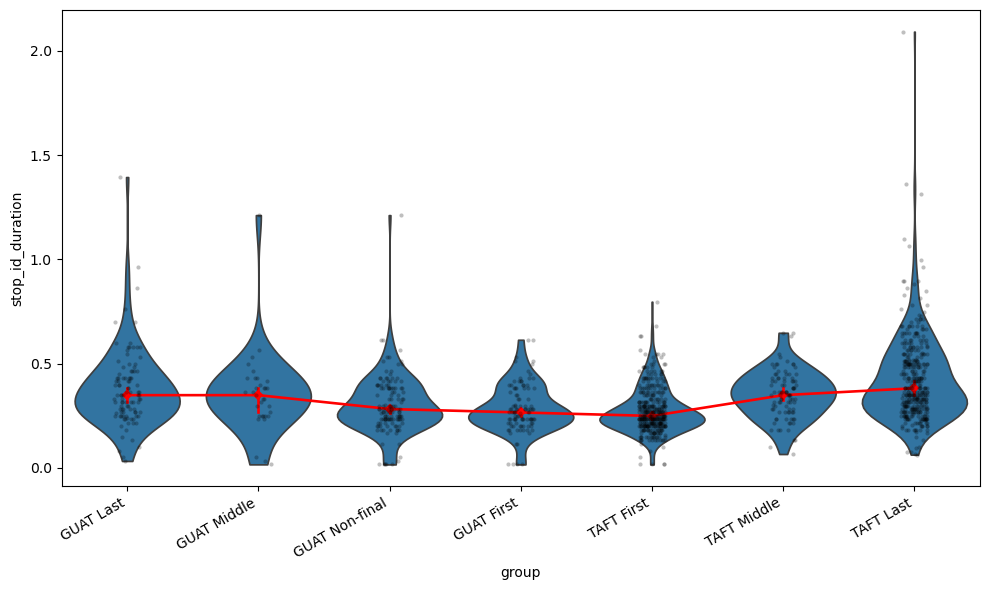

In [21]:
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df_compare, x='group', y='stop_id_duration',
    inner=None, cut=0, scale='width'
)
sns.stripplot(
    data=df_compare, x='group', y='stop_id_duration',
    color='k', alpha=0.25, size=3
)
sns.pointplot(
    data=df_compare, x='group', y='stop_id_duration',
    estimator='median', color='red', markers='D', scale=0.7
)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


In [22]:
df_compare

,stop_cluster_id,trial,num_stops,stop_point_index,first_stop_point_index,second_stop_point_index,last_stop_point_index,first_stop_time,second_stop_time,last_stop_time,stop_cluster_size,stop_id_duration,stop_time,stop_id,stop_id_start_time,stop_id_end_time,cluster_size,order_in_cluster,is_first,is_last,is_middle,group
0,15,3,2,5747,5702,5747,5747,94.65234,95.39910,95.39910,2,0.28231,95.39910,22,95.38238,95.66469,2,1,False,True,False,GUAT Last
1,42,18,3,8572,8496,8529,8572,140.60032,141.14810,141.86192,3,0.31541,141.86192,61,141.84532,142.16071,3,2,False,True,False,GUAT Last
2,57,27,2,10248,10196,10248,10248,168.53760,169.40078,169.40078,2,0.33196,169.40078,83,169.38417,169.71614,2,1,False,True,False,GUAT Last
3,77,43,2,12524,12485,12524,12524,206.08610,206.73346,206.73346,2,0.31541,206.73346,111,206.71681,207.03225,2,1,False,True,False,GUAT Last
4,124,78,2,17250,17211,17250,17250,283.54020,284.18744,284.18744,2,0.28220,284.18744,170,284.17089,284.45304,2,1,False,True,False,GUAT Last
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,1487,1056,3,217054,216975,217017,217054,3571.25798,3571.95520,3572.56940,3,0.44816,3572.56940,2097,3572.55287,3573.00099,3,2,False,True,False,TAFT Last
376,1488,1057,2,217190,217122,217190,217190,3573.66498,3574.79346,3574.79346,2,0.63111,3574.79346,2099,3574.77691,3575.40794,2,1,False,True,False,TAFT Last
377,1493,1061,2,217874,217834,217874,217874,3585.35112,3586.01516,3586.01516,2,0.63079,3586.01516,2105,3585.99855,3586.62936,2,1,False,True,False,TAFT Last
378,1495,1063,2,218482,218442,218482,218482,3595.37736,3596.04138,3596.04138,2,0.49790,3596.04138,2108,3596.02478,3596.52273,2,1,False,True,False,TAFT Last


In [23]:
df_compare

,stop_cluster_id,trial,num_stops,stop_point_index,first_stop_point_index,second_stop_point_index,last_stop_point_index,first_stop_time,second_stop_time,last_stop_time,stop_cluster_size,stop_id_duration,stop_time,stop_id,stop_id_start_time,stop_id_end_time,cluster_size,order_in_cluster,is_first,is_last,is_middle,group
0,15,3,2,5747,5702,5747,5747,94.65234,95.39910,95.39910,2,0.28231,95.39910,22,95.38238,95.66469,2,1,False,True,False,GUAT Last
1,42,18,3,8572,8496,8529,8572,140.60032,141.14810,141.86192,3,0.31541,141.86192,61,141.84532,142.16071,3,2,False,True,False,GUAT Last
2,57,27,2,10248,10196,10248,10248,168.53760,169.40078,169.40078,2,0.33196,169.40078,83,169.38417,169.71614,2,1,False,True,False,GUAT Last
3,77,43,2,12524,12485,12524,12524,206.08610,206.73346,206.73346,2,0.31541,206.73346,111,206.71681,207.03225,2,1,False,True,False,GUAT Last
4,124,78,2,17250,17211,17250,17250,283.54020,284.18744,284.18744,2,0.28220,284.18744,170,284.17089,284.45304,2,1,False,True,False,GUAT Last
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,1487,1056,3,217054,216975,217017,217054,3571.25798,3571.95520,3572.56940,3,0.44816,3572.56940,2097,3572.55287,3573.00099,3,2,False,True,False,TAFT Last
376,1488,1057,2,217190,217122,217190,217190,3573.66498,3574.79346,3574.79346,2,0.63111,3574.79346,2099,3574.77691,3575.40794,2,1,False,True,False,TAFT Last
377,1493,1061,2,217874,217834,217874,217874,3585.35112,3586.01516,3586.01516,2,0.63079,3586.01516,2105,3585.99855,3586.62936,2,1,False,True,False,TAFT Last
378,1495,1063,2,218482,218442,218482,218482,3595.37736,3596.04138,3596.04138,2,0.49790,3596.04138,2108,3596.02478,3596.52273,2,1,False,True,False,TAFT Last


In [24]:
df_compare['stop_id_duration'] = df_compare['stop_id_duration'].astype(float)

In [25]:
df_compare['stop_id_duration'].dtype


dtype('float64')

In [26]:
from itertools import combinations
from scipy.stats import mannwhitneyu

groups = df_compare['group'].unique()
pairs = list(combinations(groups, 2))

for g1, g2 in pairs:
    x1 = df_compare.loc[df_compare['group'] == g1, 'stop_id_duration']
    x2 = df_compare.loc[df_compare['group'] == g2, 'stop_id_duration']
    stat, p = mannwhitneyu(x1, x2, alternative='two-sided')
    print(f'{g1} vs {g2}: p = {p:.4f}')


GUAT Last vs GUAT Middle: p = 0.4602
GUAT Last vs GUAT Non-final: p = 0.0001
GUAT Last vs GUAT First: p = 0.0000
GUAT Last vs TAFT First: p = 0.0000
GUAT Last vs TAFT Middle: p = 0.6650
GUAT Last vs TAFT Last: p = 0.0268
GUAT Middle vs GUAT Non-final: p = 0.0503
GUAT Middle vs GUAT First: p = 0.0119
GUAT Middle vs TAFT First: p = 0.0008
GUAT Middle vs TAFT Middle: p = 0.6188
GUAT Middle vs TAFT Last: p = 0.0292
GUAT Non-final vs GUAT First: p = 0.3452
GUAT Non-final vs TAFT First: p = 0.0197
GUAT Non-final vs TAFT Middle: p = 0.0005
GUAT Non-final vs TAFT Last: p = 0.0000
GUAT First vs TAFT First: p = 0.3211
GUAT First vs TAFT Middle: p = 0.0000
GUAT First vs TAFT Last: p = 0.0000
TAFT First vs TAFT Middle: p = 0.0000
TAFT First vs TAFT Last: p = 0.0000
TAFT Middle vs TAFT Last: p = 0.0044


In [27]:
from scipy.stats import kruskal

# omnibus across groups
samples = [df_compare.loc[df_compare['group'] == g, 'stop_id_duration'] for g in df_compare['group'].unique()]
kw_stat, kw_p = kruskal(*samples)
print(f'Overall Kruskal–Wallis: H={kw_stat:.3f}, p={kw_p:.2e}')


Overall Kruskal–Wallis: H=199.365, p=2.59e-40


In [28]:
df_compare['stop_id_duration'].isna().value_counts()


stop_id_duration
False    1223
Name: count, dtype: int64

In [29]:
df_compare.groupby('group')['stop_id_duration'].median().sort_values()


group
TAFT First       0.24902
GUAT First       0.26562
GUAT Non-final   0.28213
GUAT Last        0.34857
TAFT Middle      0.34861
GUAT Middle      0.34862
TAFT Last        0.38183
Name: stop_id_duration, dtype: float64

In [30]:
pn.GUAT_trials_df

,stop_cluster_id,trial,num_stops,stop_indices,first_stop_point_index,second_stop_point_index,last_stop_point_index,first_stop_time,second_stop_time,last_stop_time,stop_cluster_size,stop_id_duration
0,15,3,2,"[5702, 5747]",5702,5747,5747,94.65234,95.39910,95.39910,2,0.28231
1,42,18,3,"[8496, 8529, 8572]",8496,8529,8572,140.60032,141.14810,141.86192,3,0.33207
2,57,27,2,"[10196, 10248]",10196,10248,10248,168.53760,169.40078,169.40078,2,0.41497
3,77,43,2,"[12485, 12524]",12485,12524,12524,206.08610,206.73346,206.73346,2,0.31544
4,124,78,2,"[17211, 17250]",17211,17250,17250,283.54020,284.18744,284.18744,2,0.28214
...,...,...,...,...,...,...,...,...,...,...,...,...
96,1425,1007,2,"[206837, 206863]",206837,206863,206863,3404.39797,3404.82955,3404.82955,2,0.14939
97,1452,1030,3,"[210812, 210859, 210907]",210812,210859,210907,3469.75091,3470.53112,3471.32789,3,0.69715
98,1465,1039,3,"[213126, 213169, 213220]",213126,213169,213220,3507.86322,3508.57700,3509.42334,3,0.56426
99,1468,1041,4,"[213539, 213585, 213685, 213716]",213539,213585,213716,3514.67073,3515.41670,3517.59125,4,1.21171


In [31]:
now i want to also add GUAT_first, TAFT_first, GUAT_middle, TAFT_middle,capture_TAFT_last, etc, into comparison

SyntaxError: invalid syntax (2998872254.py, line 1)